# Language Identification 

goal : Implement a language identifier that can detect the language of tweets.  

We will train with tree different models : 1. SGC classifier (SVM, L2 regularizer), 2. Multinomial Naive Bayse classifer and 3. Multi layer perceptron and compare their F1 score. To find best model, we will try out different combination of hyperparemeter using grid search. Finally, we will evaluate the model accuracy with confusion matrix. 

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load dataset 

Let's get the dataset using native REST API and load it as a dataframe using pandas

In [2]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [3]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [4]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

### 2. Inspect dataset

In [5]:
print('Infos train-dev-set:')
print(df_train_dev.info())

Infos train-dev-set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52675 entries, 0 to 52674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   52675 non-null  object
 1   label   52675 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB
None


In [6]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


In [7]:
# check the number of languages (label) in the datset 

print(df_train_dev.label.unique())
print(len(df_train_dev.label.unique()))

['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr' 'ht'
 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN' 'ms'
 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt' 'ro' 'ru' 'si' 'sl' 'sq' 'sr'
 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th' 'tl' 'tn' 'tr' 'uk' 'und' 'ur'
 'ur_LATN' 'vi' 'wo' 'xh' 'zh-CN' 'zh-TW']
69


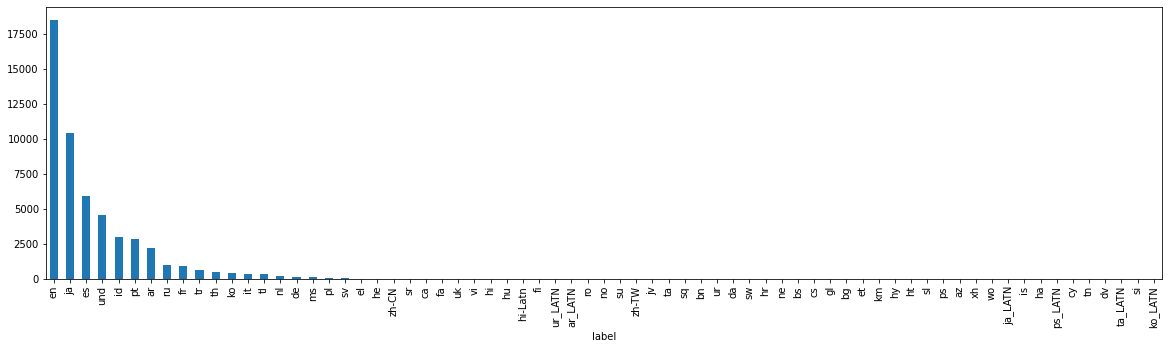

In [8]:
# check the language distribution with bar chart 

df_train_dev.groupby('label').size().sort_values(ascending = False).plot.bar(figsize=(20, 5))

In [9]:
df_train_dev.groupby('label').size().sort_values(ascending = False)

label
en         18508
ja         10421
es          5930
und         4537
id          3006
           ...  
tn             1
dv             1
ta_LATN        1
si             1
ko_LATN        1
Length: 69, dtype: int64

We can confirm that there is huge class imbalance between top 10 classes and the rest of them. One way to resolve this is unifying very rare classes (e.g. class with one member) and upsampling them.

### 3. Balancing classes 

In [10]:
# df_train_dev['label'] = df_train_dev['label'].apply(lambda x: x.strip().lower())
# df_test['label'] = df_test['label'].apply(lambda x: x.strip().lower())

In [11]:
def unify_singleton_classes(df, threshold):
    counts = df['label'].value_counts()
    rare_labels = [label for label in counts[counts < threshold].index]
    df.loc[(df.label.isin(rare_labels)), 'label'] = 'und'
    return df

df_train_dev_uni = unify_singleton_classes(df_train_dev, 3)

In [12]:
from sklearn.utils import resample

def upsample_rare_classes(df, threshold, sample_size):
    """Copy low frequent Tweets of languages, that have a number 
    of tweets below a certain threshold.
    
    :param data_train: dataframe
    :param threshold: int
    :param sample_size: int
    """
    class_counts = defaultdict(int)
    classes_to_upsample = set()
    for index, row in df.iterrows():
        class_counts[row['label']] += 1
    for label, count in class_counts.items():
        if count < threshold:
            classes_to_upsample.add(label)
    df_to_upsample = df[df['label'].isin(classes_to_upsample)]
    upsampled_classes = pd.DataFrame(resample(df_to_upsample.to_numpy(), replace=True, n_samples=sample_size, random_state=42))
    upsampled_classes.columns = ['tweet', 'label']
    return pd.concat([df, upsampled_classes]).sample(frac=1)

df_train_dev_up = upsample_rare_classes(df=df_train_dev_uni, threshold=50, sample_size=2000)

In [13]:
print(df_train_dev.shape)
print(df_train_dev_up.shape)

(52675, 2)
(54675, 2)


### 4. Label encoding

In [14]:
from sklearn.preprocessing import LabelEncoder
le_fitted = LabelEncoder().fit(df_train_dev_up['label'])

In [15]:
# map all classes that are not in train_dev to undefined
for i, label in enumerate(df_test['label']):
    df_test['label'][i] = 'und' if label not in le_fitted.classes_ else label
    
# check if it worked: should return an empty list
print([label for label in df_test['label'] if label not in set(df_train_dev_up['label'])])

[]


In [16]:
y_train_dev, y_test = le_fitted.transform(df_train_dev_up['label']), le_fitted.transform(df_test['label'])

### 5. Preprocess Tweets data 

* **Normalization** : clean the tweets by removing puntuation, newlines, white space and make them lowercase 

* **Feature extraction** : build bigram, compute vowel/consonant ratio, capitalization ration and count frequency of double characters

* **Count vectorizer** : Convert a collection of text documents to a matrix of token counts

* **one-hot encoding** : 

Pipeline classes:

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


class TweetNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 

    def _normalize_tweet(self, tweet):
        """Remove punctuation and newlines, lowercase, pad with spaces.

        :param tweet: string
        :return: normalized string
        """
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        tweet = re.sub(r'\n', r'', tweet)
        tweet = tweet.lower()
        tweet = re.sub(r'@\w+\b', r'', tweet)
        tweet = re.sub(r'\b\S+//\S+\b', r'', tweet)
        # tweet = ' ' + tweet + ' '
        return tweet
    
    def transform(self, X, y=None):
        tweets = []
        for tweet in X:
            tweets.append(self._normalize_tweet(tweet))
        return np.array(tweets)


class FeatureExtractor(BaseEstimator, TransformerMixin):


    vowels = set([c for c in 'aeiouäöüàéèëï'])
    consonants = set([c for c in 'bcdfghklmnlpqrstvwxyz'])

    def __init__(self):
        self.scaler = MinMaxScaler()

    def _to_bigrams(self, tweet):
        return [bg[0] + bg[1] for bg in zip(tweet, tweet[1:])]

    def _get_vowel_consonant_ratio(self, tweet):
        vf = 0
        cf = 0
        for c in tweet.lower():
            if c in self.vowels:
                vf =+ 1
            elif c in self.consonants:
                cf += 1
        return vf / (cf + 1)

    def _get_capitalization_ratio(self, tweet):
        up_count = 0
        for c in tweet:
            if c.upper() == c:
                up_count += 1
        return up_count / (len(tweet) + 1)

    def _get_double_char_freq(self, tweet):
        double_freq = 0
        for bg in self._to_bigrams(tweet):
            if bg[0] == bg[1]:
                double_freq += 1
        return double_freq
    
    def _extract_num_features(self, tweets):
        num_features = []
        for tweet in tweets:
            feat_tweet = []
            feat_tweet.append(self._get_vowel_consonant_ratio(tweet))
            feat_tweet.append(self._get_capitalization_ratio(tweet))
            feat_tweet.append(self._get_double_char_freq(tweet))
            num_features.append(feat_tweet)
        return np.array(num_features)
    
    def fit(self, X, y=None):
        numerical_features = self._extract_num_features(X)
        self.scaler.fit(numerical_features)
        return self
    
    def transform(self, X, y=None):
        numerical_features= self._extract_num_features(X)
        return X, self.scaler.transform(numerical_features)


class MatrixToArrayConverter1(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[0].toarray(), X[1]


class MatrixUnifier(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.concatenate([X[0].todense(), X[1]], axis=1)


class CountVectorizerWrapper:

    def __init__(self, ngram_range, analyzer, max_features, binary):
        print('args:', str([ngram_range, analyzer, max_features, binary]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer, max_features=max_features, binary=binary)
    
    def fit(self, X, y=None):
        tweets, numerical_features = X
        self.countvec.fit(tweets)
        return self
    
    def transform(self, X, y=None):
        tweets, numerical_features = X
        return self.countvec.transform(tweets), numerical_features


class OneHotEncoderWrapper:

    def __init__(self, handle_unknown):
        self.ohe = OneHotEncoder(handle_unknown=handle_unknown)
    
    def fit(self, X, y=None):
        self.ohe.fit(X[0])
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(X[0]), X[1]


Helper classes for the pipeline:

In [18]:
class GenericClassifier(BaseEstimator):

    def __init__(self, estimator):
        self.clf = clf


    def fit(self, X, y=None, **kwargs):
        self.clf.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.clf.predict(X)


    def predict_proba(self, X):
        return self.clf.predict_proba(X)


    def score(self, X, y):
        return self.clf.score(X, y)


class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        import pdb; pdb.set_trace()
        return X

    def fit(self, X, y=None, **fit_params):
        return self

### 6. Training with GridSearch 

Try different hyperparameter to acheive optimal model using GridSearch

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [25]:
clf_param_grid = {
    'MultinomialNB': [MultinomialNB, {'CLF__alpha': [0.1, 1]}],
    'SGDClassifier': [SGDClassifier, {'CLF__loss': ['hinge', 'log'], 'CLF__penalty': ['l2', 'l1'], 'CLF__max_iter': [100, 300], 'CLF__early_stopping': [True, False]}],
    'MLPClassifier': [MLPClassifier, {'CLF__hidden_layer_sizes': (50, 100),'CLF__max_iter': (20,),'CLF__activation': ('logistic', 'relu'),'CLF__solver': ('sgd', 'adam'),'CLF__early_stopping': (True, False),}]
}

In [26]:
models = []

for clf_name in  clf_param_grid:
    print(30*'-')
    print(clf_name)
    param_grid = clf_param_grid[clf_name][1]
    print(param_grid)
    bigram_vec_args = dict(ngram_range=(2,2), analyzer='char_wb', max_features=100, binary=True)
    
    pipe = Pipeline(steps=[
        ('TweetNormalizer', TweetNormalizer()),
        ('FeatureExtractor', FeatureExtractor()),
        ('BigramVectorizer', CountVectorizerWrapper(**bigram_vec_args)),
        ('MatrixToArrayConverter', MatrixToArrayConverter1()),
        ('OneHotEncoder', OneHotEncoderWrapper(handle_unknown='ignore')),
        ('MatrixUnifier', MatrixUnifier()),
        ('CLF', clf_param_grid[clf_name][0]())
    ], verbose=True)

    grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, scoring='f1_micro', cv=10)
    grid.fit(df_train_dev_up['tweet'].to_numpy(), y_train_dev)

    models.append(grid)

------------------------------
MultinomialNB
{'CLF__alpha': [0.1, 1]}
args: [(2, 2), 'char_wb', 100, True]
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.5s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=  10.8s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.6s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.5s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.8s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.7s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.6s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.5s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.1s
------------------------------
SGDClassifier
{'CLF__loss': ['hinge', 'log'], 'CLF__penalty': ['l2', 'l1'], 'CLF__max_iter': [100, 300], 'CLF__early_stopping': [True, False]}
args: [(2, 2), 'char_wb', 100, True]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.6s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  35.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  30.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  28.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  29.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  27.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  28.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  28.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.7s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  40.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  40.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  40.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  40.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  39.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  46.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  48.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  47.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  52.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  47.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  50.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  21.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  20.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  50.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  47.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  50.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  49.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  51.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  51.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  22.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  23.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.3s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.6s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.9s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  24.5s
------------------------------
MLPClassifier
{'CLF__hidden_layer_sizes': (50, 100), 'CLF__max_iter': (20,), 'CLF__activation': ('logistic', 'relu'), 'CLF__solver': ('sgd', 'adam'), 'CLF__early_stopping': (True, False)}
args: [(2, 2), 'char_wb', 100, True]
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.4s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.8s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.2s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.6s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.6s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.6s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  16.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.6s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.3s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  17.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   6.2s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.4s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   6.3s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  14.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.3s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.7s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.7s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.8s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.1s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   7.7s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.0s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.9s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.1s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   5.3s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   4.9s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.2s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   1.3s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   5.5s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   6.9s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.4s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[Pipeline] ............... (step 7 of 7) Processing CLF, total=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### 7. Report results

* NBC
* SGD 
*MLP 

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### NBC 

Micro f1-Score of the naive base models on the dev set:

In [ ]:
models[0].cv_results_

In [29]:
grid_df = pd.DataFrame.from_dict(models[0].cv_results_)
grid_df.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CLF__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,13.575156,1.608423,0.673924,0.072160,0.1,{'CLF__alpha': 0.1},0.612838,0.612107,0.617410,0.61741,0.627103,0.625206,0.623194,0.616243,0.631791,0.624108,0.620741,0.006159,1
1,13.128490,0.713284,0.660757,0.066933,1,{'CLF__alpha': 1},0.611010,0.610461,0.615582,0.61485,0.622714,0.622462,0.619718,0.613499,0.632522,0.620816,0.618363,0.006359,2


Micro and macro f1-score of the best naive bayes model on the test set:

In [30]:
preds = models[0].predict(df_test['tweet'].to_numpy())
f1_micro = f1_score(preds, y_test, average='micro')
f1_macro = f1_score(preds, y_test, average='macro')

print(f'F1-micro-score on the testset: {f1_micro}')
print(f'F1-macro-score on the testset: {f1_macro}')

F1-micro-score on the testset: 0.6298667068303336
F1-macro-score on the testset: 0.1891293449074721


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [31]:
print(preds)

[ 9  0 43 ... 10 22 32]


In [32]:
# calculate accuracy

correct = 0

for index, prediction in enumerate(preds):
  if prediction == y_test[index]:
    correct += 1

print('Accuracy: ', correct/y_test.shape[0])


Accuracy:  0.6298667068303336


#### SGD 

Micro f1-Score of the SGD models on the dev set:

In [41]:
grid_df = pd.DataFrame.from_dict(models[1].cv_results_)
grid_df.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CLF__early_stopping,param_CLF__loss,param_CLF__max_iter,param_CLF__penalty,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
12,35.797754,0.710768,0.603267,0.061741,False,log,100,l2,"{'CLF__early_stopping': False, 'CLF__loss': 'l...",0.741039,...,0.727871,0.733175,0.741174,0.738979,0.740077,0.744284,0.753796,0.739479,0.006951,1
14,35.539045,0.540567,0.600661,0.066030,False,log,300,l2,"{'CLF__early_stopping': False, 'CLF__loss': 'l...",0.738661,...,0.726957,0.728237,0.753430,0.732943,0.739345,0.738065,0.747028,0.737778,0.007564,2
15,80.157865,1.452212,0.606213,0.059454,False,log,300,l1,"{'CLF__early_stopping': False, 'CLF__loss': 'l...",0.726408,...,0.734089,0.735735,0.719224,0.730199,0.732394,0.741174,0.730748,0.732016,0.005984,3
13,80.856232,1.104429,0.593191,0.065109,False,log,100,l1,"{'CLF__early_stopping': False, 'CLF__loss': 'l...",0.721653,...,0.732443,0.732992,0.742455,0.726724,0.734041,0.738796,0.726907,0.731925,0.005780,4
10,32.990941,0.673840,0.595864,0.063429,False,hinge,300,l2,"{'CLF__early_stopping': False, 'CLF__loss': 'h...",0.713789,...,0.726957,0.729883,0.738613,0.723431,0.730199,0.735504,0.731846,0.727774,0.006785,5
8,32.601565,0.810231,0.595564,0.066361,False,hinge,100,l2,"{'CLF__early_stopping': False, 'CLF__loss': 'h...",0.727140,...,0.733723,0.725128,0.730016,0.714286,0.737333,0.719224,0.743918,0.727718,0.008454,6
11,62.243941,1.304949,0.601933,0.062877,False,hinge,300,l1,"{'CLF__early_stopping': False, 'CLF__loss': 'h...",0.715252,...,0.709583,0.714887,0.730565,0.710444,0.724529,0.724895,0.714469,0.717787,0.006399,7
9,61.810843,1.792518,0.604994,0.070387,False,hinge,100,l1,"{'CLF__early_stopping': False, 'CLF__loss': 'h...",0.694038,...,0.708851,0.711412,0.719773,0.706603,0.708981,0.718859,0.723797,0.712337,0.008040,8
5,52.524757,0.710305,0.640997,0.062552,True,log,100,l1,"{'CLF__early_stopping': True, 'CLF__loss': 'lo...",0.702451,...,0.699159,0.700256,0.722700,0.698921,0.693433,0.710079,0.703311,0.704545,0.008123,9
7,52.151403,0.579809,0.645374,0.068883,True,log,300,l1,"{'CLF__early_stopping': True, 'CLF__loss': 'lo...",0.700988,...,0.697696,0.712875,0.709896,0.662155,0.707152,0.704591,0.715566,0.703136,0.014627,10


Micro and macro f1-score  the best SGD model on the test set:

In [39]:
preds = models[1].predict(df_test['tweet'].to_numpy())
f1_micro = f1_score(preds, y_test, average='micro')
f1_macro = f1_score(preds, y_test, average='macro')
print(f'F1-micro-score on the testset: {f1_micro}')
print(f'F1-macro-score on the testset: {f1_macro}')

F1-micro-score on the testset: 0.7621055802394759
F1-macro-score on the testset: 0.22044826519222274


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [40]:
# calculate accuracy

correct = 0

for index, prediction in enumerate(preds):
  if prediction == y_test[index]:
    correct += 1

print('Accuracy: ', correct/y_test.shape[0])


Accuracy:  0.7621055802394758


#### MLP

In [42]:
grid_df = pd.DataFrame.from_dict(models[2].cv_results_)
grid_df.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CLF__activation,param_CLF__early_stopping,param_CLF__hidden_layer_sizes,param_CLF__max_iter,param_CLF__solver,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
11,25.353098,1.046013,0.665189,0.064475,relu,True,100,20,adam,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.771214,0.768471,0.783611,0.776111,0.778672,0.779587,0.775014,0.773919,0.006843,1
15,26.182120,1.234768,0.679012,0.068078,relu,False,100,20,adam,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.775055,0.776884,0.780867,0.775380,0.772453,0.780684,0.772636,0.773919,0.004789,2
9,22.382715,0.997460,0.665421,0.069258,relu,True,50,20,adam,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.759510,0.757132,0.772453,0.763673,0.766417,0.767514,0.767148,0.764079,0.005349,3
13,23.104832,1.205283,0.659968,0.062112,relu,False,50,20,adam,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.760424,0.762253,0.765685,0.761844,0.769160,0.764770,0.765136,0.763695,0.003547,4
7,27.993065,0.595108,0.720212,0.114195,logistic,False,100,20,adam,"{'CLF__activation': 'logistic', 'CLF__early_st...",...,0.746159,0.759693,0.768429,0.762758,0.767331,0.761478,0.765868,0.760403,0.006600,5
3,26.845431,0.898564,0.724595,0.137451,logistic,True,100,20,adam,"{'CLF__activation': 'logistic', 'CLF__early_st...",...,0.753292,0.754938,0.762210,0.752515,0.762210,0.762575,0.760929,0.757531,0.004750,6
5,23.752508,0.739862,0.673690,0.064628,logistic,False,50,20,adam,"{'CLF__activation': 'logistic', 'CLF__early_st...",...,0.735369,0.747623,0.758917,0.748491,0.751783,0.754527,0.753978,0.749411,0.007298,7
1,23.279632,0.735018,0.718294,0.184231,logistic,True,50,20,adam,"{'CLF__activation': 'logistic', 'CLF__early_st...",...,0.740490,0.744696,0.758185,0.747211,0.750320,0.753064,0.748308,0.747600,0.005014,8
14,25.320510,0.380053,0.681855,0.066166,relu,False,100,20,sgd,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.708120,0.711412,0.719956,0.708432,0.714834,0.722151,0.715200,0.711807,0.006601,9
10,24.523824,0.631555,0.667320,0.061211,relu,True,100,20,sgd,"{'CLF__activation': 'relu', 'CLF__early_stoppi...",...,0.706657,0.706840,0.710262,0.705689,0.705872,0.721419,0.705872,0.708368,0.004772,10


In [ ]:
models[2].cv_results_

In [36]:
preds = models[2].predict(df_test['tweet'].to_numpy())
f1_micro = f1_score(preds, y_test, average='micro')
f1_macro = f1_score(preds, y_test, average='macro')
print(f'F1-micro-score on the testset: {f1_micro}')
print(f'F1-macro-score on the testset: {f1_macro}')

F1-micro-score on the testset: 0.7854507116499735
F1-macro-score on the testset: 0.2576343810253325


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [38]:
# calculate accuracy

correct = 0

for index, prediction in enumerate(preds):
  if prediction == y_test[index]:
    correct += 1

print('Accuracy: ', correct/y_test.shape[0])


Accuracy:  0.7854507116499736


### 8. Confusion matrix
Let's check the confusion matrix:

In [37]:
num_classes = len(le_fitted.classes_)
def create_confusion_matrix(num_classes, preds, y_test):
    """Create confusion matrix 'by hand' since test set does not contain all labels"""
    df = pd.DataFrame(np.zeros((num_classes, num_classes), dtype=int))
    for i, j in zip(preds, y_test):
        df.iloc[i, j] += 1
    df.columns = le_fitted.classes_
    df.index = le_fitted.classes_
    return df
df = create_confusion_matrix(num_classes, preds, y_test)
df

,ar,ar_LATN,bn,bs,ca,cs,da,de,el,en,...,th,tl,tr,uk,und,ur,ur_LATN,vi,zh-CN,zh-TW
ar,192,0,0,0,0,0,0,0,0,1,...,9,0,0,0,6,1,0,0,0,1
ar_LATN,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
bn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bs,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ca,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
cs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
da,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de,0,0,0,0,0,0,0,27,0,2,...,0,0,0,0,0,0,0,0,0,0
el,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
en,2,1,0,0,1,0,1,14,1,4348,...,2,11,15,0,183,0,0,0,0,0
